In [1]:
import torch
import numpy as np
import torch.nn as nn
from scipy import integrate
from scipy.special import softmax 

import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'font.size': 18,
})

# Set parameters
device = torch.device('cpu')

# set seed
torch.manual_seed(0)
np.random.seed(1)

## Define model

In [2]:
class ReverseODE_TimeChange(nn.Module):
    def __init__(self, train_data):
        super().__init__()
        self.train_data = train_data
        self.beta = 1.0

    def marginal_std(self, t):
        return np.exp(-1.0*t)

    def pdf_weights(self, x, t):
        # compute sigma
        sigma = self.marginal_std(t)
        # evaluate Gaussian densities
        logpdf_x_yi = np.zeros((x.shape[0],self.train_data.shape[0]))
        for i in range(self.train_data.shape[0]):
            logpdf_x_yi[:,i] = self.log_normal_pdf(x, self.train_data[i,:], sigma)
        # compute weighted average
        return softmax(logpdf_x_yi, axis=1)
        
    def log_normal_pdf(self, x, y, sigma):
        # ignoring normalization constant
        assert(x.shape[0] == len(sigma))
        return -0.5*np.sum((x - y)**2,axis=1)/sigma**2

    def normalized_weights(self, x, t):
        # compute weights
        weights = self.pdf_weights(x, t)     
        # compute weighted average
        evals = np.matmul(weights, self.train_data) 
        # check NaNs for zero weights
        evals[np.isnan(evals)] = 0.0
        return evals

    def ODEsampler(self, latents, T0=0.0, T1=1.0, err_tol=1e-5):

        # The ODE function for use by the ODE solver
        def ode_func(t, x):
            batch_time   = np.ones((latents.shape[0],)) * t
            batch_sample = x.reshape(latents.shape)
            rhs = - (batch_sample - self.normalized_weights(batch_sample, batch_time))
            return rhs.reshape((-1,))

        # Run the black-box ODE solver
        res = integrate.solve_ivp(ode_func, (T0, T1), latents.reshape(-1), rtol=err_tol, atol=err_tol, method='RK45')
        return res.y.reshape((latents.shape[0],latents.shape[1],len(res.t))), res.t


## Define Data: 4 points

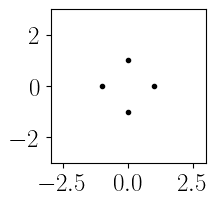

In [3]:
dim  = 4
data = np.array([[-1,0],[1,0],[0,-1],[0,1]])

# plot data points
plt.figure(figsize=(2,2))
plt.plot(data[:,0],data[:,1],'.k')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

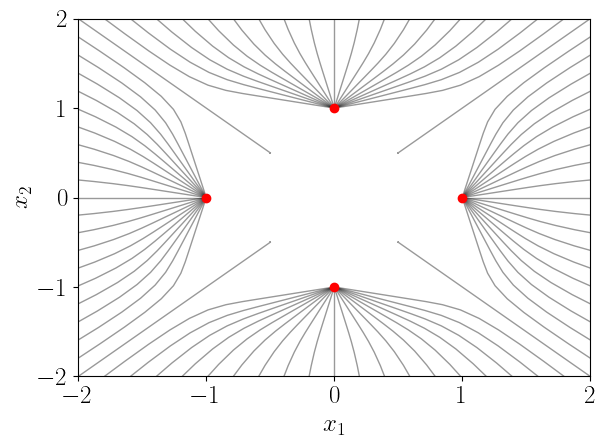

In [4]:
# define GMM
gmm = ReverseODE_TimeChange(data)

# define latent samples
scaling    = 2.1
batch_size = 21
latent_x   = scaling*torch.linspace(-1,1,batch_size)[np.newaxis,:]
latents_1  = torch.vstack((latent_x, scaling*torch.ones(1,batch_size))).T
latents_2  = torch.vstack((latent_x, -scaling*torch.ones(1,batch_size))).T
latents_3  = torch.vstack((scaling*torch.ones(1,batch_size-2), latent_x[:,1:-1])).T 
latents_4  = torch.vstack((-scaling*torch.ones(1,batch_size-2),latent_x[:,1:-1])).T
latents    = torch.vstack((latents_1, latents_2, latents_3, latents_4))

# evaluate ODE and SDE paths
GMM_x, GMM_t = gmm.ODEsampler(latents, T1=100.0, err_tol=1e-7)

ctr = 1
plt.figure()
for i in range(latents.shape[0]):
    plt.plot(GMM_x[i,0,:], GMM_x[i,1,:], '-k', alpha=0.4, linewidth=1)
plt.plot(data[:,0],data[:,1],'.r',markersize=12)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.tight_layout()
plt.savefig('figures/HyerplaneBoundary/4points.pdf')

## Define data: 2 points

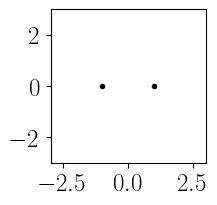

In [5]:
dim  = 2
data = np.array([[-1,0],[1,0]])

# plot data points
plt.figure(figsize=(2,2))
plt.plot(data[:,0],data[:,1],'.k')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

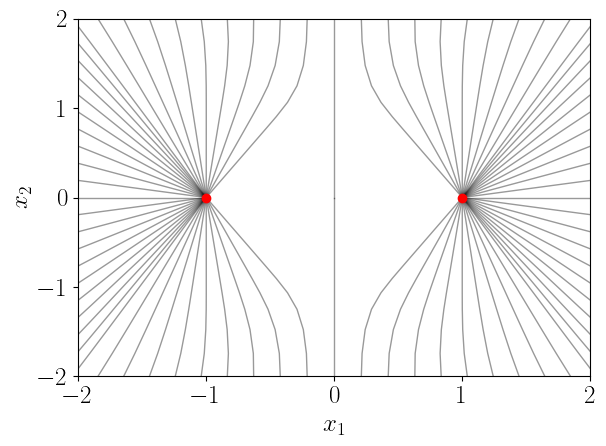

In [6]:
# define GMM
gmm = ReverseODE_TimeChange(data)

# define latent samples
scaling    = 2.1
batch_size = 21
latent_x   = scaling*torch.linspace(-1,1,batch_size)[np.newaxis,:]
latents_1  = torch.vstack((latent_x, scaling*torch.ones(1,batch_size))).T
latents_2  = torch.vstack((latent_x, -scaling*torch.ones(1,batch_size))).T
latents_3  = torch.vstack((scaling*torch.ones(1,batch_size-2), latent_x[:,1:-1])).T 
latents_4  = torch.vstack((-scaling*torch.ones(1,batch_size-2),latent_x[:,1:-1])).T
latents    = torch.vstack((latents_1, latents_2, latents_3, latents_4))

# evaluate ODE and SDE paths
GMM_x, GMM_t = gmm.ODEsampler(latents, T1=100.0, err_tol=1e-7)

ctr = 1
plt.figure()
for i in range(latents.shape[0]):
    plt.plot(GMM_x[i,0,:], GMM_x[i,1,:], '-k', alpha=0.4, linewidth=1)
plt.plot(data[:,0],data[:,1],'.r',markersize=12)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.tight_layout()
plt.savefig('figures/HyerplaneBoundary/2points.pdf')